In [ ]:
import pickle

In [ ]:
import torch

with open("../feed_dict.json","rb") as file:
    feed_dict = pickle.load(file)

In [ ]:
feed_dict_q = feed_dict
feed_dict_k = feed_dict

In [ ]:
import torch

feed_dict_q["view"] = torch.rand((feed_dict["image"].size(0),1,7))
feed_dict_k["view"] = torch.rand((feed_dict["image"].size(0),1,7))

In [ ]:
import sys
sys.path.append("../")

In [ ]:
from core.scene_graph.scene_graph import SceneGraph
from torchvision.models import resnet34
import torch.nn as nn
import torch

In [ ]:
resnet = resnet34(pretrained=True)
feature_extractor = nn.Sequential(*list(resnet.children())[:-3])
scene_graph = SceneGraph(feature_dim=256, 
                         output_dims=[256,256],
                         downsample_rate=16)

In [ ]:
def get_scene_graph(feed_dict):
    image_features = feature_extractor(feed_dict["image"])
    outputs = scene_graph(image_features, feed_dict["objects"], feed_dict["objects_length"])
    
    return outputs

In [ ]:
def merge_pose_with_scene_embeddings(scene_embeddings, view):

    for ind,(visual_embeddings, spatial_embeddings) in enumerate(scene_embeddings):

        # Broadcast view to visual embedding dimension
        view_visual = view[ind].repeat(visual_embeddings.shape[0],1)
        # Concatenate with visual embeddings
        pose_with_features = torch.cat((view_visual,visual_embeddings), dim=1)
        # Reassign the scene embeddings
        scene_embeddings[ind][0] = pose_with_features

        # Broadcast view to spatial embedding dimension
        view_spatial = view[ind].unsqueeze(0).repeat(spatial_embeddings.shape[0],spatial_embeddings.shape[1],1)
        # Concatenate with visual embeddings
        pose_with_features = torch.cat((view_spatial,spatial_embeddings), dim=2)
        # Reassign the scene embeddings
        scene_embeddings[ind][1] = pose_with_features

        ### To Do : Write some assertion test : (Saksham)
    
    return scene_embeddings

In [ ]:
scene_embeddings_q = get_scene_graph(feed_dict_q)
scene_embeddings_k = get_scene_graph(feed_dict_k)

In [ ]:
scene_embeddings_q = merge_pose_with_scene_embeddings(scene_embeddings_q, feed_dict_q["view"])

In [ ]:
scene_embeddings_k = merge_pose_with_scene_embeddings(scene_embeddings_k, feed_dict_k["view"])

In [ ]:
visual_view_point_transformation_layer = nn.Sequential(nn.Linear(263,512),
                                                nn.ReLU(),
                                                nn.Linear(512,263))

spatial_view_point_transformation_layer = nn.Sequential(nn.Linear(263,512),
                                                nn.ReLU(),
                                                nn.Linear(512,263))

##### To DO : Reset Parameters of "view_point_transformation_layer"

In [ ]:
def do_viewpoint_transformation(scene_embeddings):
    
    for ind,(visual_embeddings, spatial_embeddings) in enumerate(scene_embeddings):
        
        # Do viewpoint transformation on visual embeddings
        scene_embeddings[ind][0] = visual_view_point_transformation_layer(scene_embeddings_k[ind][0])
        
        # Do viewpoint transformation on spatial embeddings
        scene_embeddings[ind][1] = spatial_view_point_transformation_layer(scene_embeddings_k[ind][1])
        
    return scene_embeddings
    

In [ ]:
scene_embeddings_k_transformed = do_viewpoint_transformation(scene_embeddings_k)

In [ ]:
scene_embeddings_k_transformed[0][1].shape

torch.Size([4, 4, 263])

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()   
    
        self.resnet = resnet34(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-3])
        self.scene_graph = SceneGraph(feature_dim=256, 
                                 output_dims=[256,256],
                                 downsample_rate=16)
        
        self.visual_view_point_transformation_layer = nn.Sequential(nn.Linear(263,512),
                                                nn.ReLU(),
                                                nn.Linear(512,263))

        self.spatial_view_point_transformation_layer = nn.Sequential(nn.Linear(263,512),
                                                        nn.ReLU(),
                                                        nn.Linear(512,263))

        ##### To DO : Reset Parameters of "view_point_transformation_layer"
        self.reset_parameters()
        
    def forward(self,feed_dict_k, feed_dict_q):
    
        scene_embeddings_q = get_scene_graph(feed_dict_q)
        scene_embeddings_k = get_scene_graph(feed_dict_k)
        
        scene_embeddings_q = merge_pose_with_scene_embeddings(scene_embeddings_q, feed_dict_q["view"])
        scene_embeddings_k = merge_pose_with_scene_embeddings(scene_embeddings_k, feed_dict_k["view"])
        
        scene_embeddings_k_transformed = do_viewpoint_transformation(scene_embeddings_k)
        
        return scene_embeddings_q, scene_embeddings_q, scene_embeddings_k_transformed
    

    def get_scene_graph(self,feed_dict):
        image_features = self.feature_extractor(feed_dict["image"])
        outputs = self.scene_graph(image_features, feed_dict["objects"], feed_dict["objects_length"])

        return outputs
    
    @staticmethod
    def merge_pose_with_scene_embeddings(scene_embeddings, view):

        for ind,(visual_embeddings, spatial_embeddings) in enumerate(scene_embeddings):

            # Broadcast view to visual embedding dimension
            view_visual = view[ind].repeat(visual_embeddings.shape[0],1)
            # Concatenate with visual embeddings
            pose_with_features = torch.cat((view_visual,visual_embeddings), dim=1)
            # Reassign the scene embeddings
            scene_embeddings[ind][0] = pose_with_features

            # Broadcast view to spatial embedding dimension
            view_spatial = view[ind].unsqueeze(0).repeat(spatial_embeddings.shape[0],spatial_embeddings.shape[1],1)
            # Concatenate with visual embeddings
            pose_with_features = torch.cat((view_spatial,spatial_embeddings), dim=2)
            # Reassign the scene embeddings
            scene_embeddings[ind][1] = pose_with_features

            ### To Do : Write some assertion test : (Saksham)

            return scene_embeddings
    
    @staticmethod  
    def do_viewpoint_transformation(scene_embeddings):
    
        for ind,(visual_embeddings, spatial_embeddings) in enumerate(scene_embeddings):

            # Do viewpoint transformation on visual embeddings
            scene_embeddings[ind][0] = visual_view_point_transformation_layer(scene_embeddings_k[ind][0])

            # Do viewpoint transformation on spatial embeddings
            scene_embeddings[ind][1] = spatial_view_point_transformation_layer(scene_embeddings_k[ind][1])

            return scene_embeddings
    
    def reset_parameters(self):
        pass

In [ ]:
m = Model()

In [ ]:
scene_embeddings_q, scene_embeddings_q, scene_embeddings_k_transformed = m(feed_dict_k, feed_dict_q)

In [ ]:
scene_embeddings_k[0][0].shape

torch.Size([4, 263])

In [ ]:
from core.utils import run_kmeans

In [ ]:
from attrdict import AttrDict

In [ ]:
args = AttrDict({
    'gpu':0,
    'num_cluster': [10],
    'temperature' : 1
})

In [ ]:
results = run_kmeans(torch.cat((scene_embeddings_q[0][0], scene_embeddings_q[1][0]), dim =0).detach().numpy(), args)

performing kmeans clustering


In [ ]:
results

{'im2cluster': [tensor([9, 8, 4, 8, 2, 7, 1, 1, 1, 0, 3, 5, 6], device='cuda:0')],
 'centroids': [tensor([[ 0.0113,  0.0231,  0.0844,  ...,  0.0696, -0.0091,  0.1154],
          [ 0.0083,  0.0248,  0.0840,  ...,  0.0689, -0.0131,  0.1166],
          [ 0.0117,  0.0241,  0.0954,  ...,  0.0798, -0.0108,  0.1117],
          ...,
          [ 0.0135,  0.0243,  0.0914,  ...,  0.0620, -0.0084,  0.1132],
          [-0.0028,  0.0136,  0.0810,  ...,  0.0708, -0.0171,  0.1242],
          [ 0.0020,  0.0078,  0.0880,  ...,  0.0703, -0.0090,  0.1274]],
         device='cuda:0')],
 'density': [tensor([1.0023, 1.0023, 1.0023, 1.0023, 1.0023, 1.0023, 1.0023, 1.0023, 0.9793,
          1.0023], device='cuda:0')]}

In [ ]:
results

{'im2cluster': [tensor([9, 8, 4, 8, 2, 7, 1, 1, 2, 0, 3, 5, 6], device='cuda:0')],
 'centroids': [tensor([[ 2.2027e-01,  1.1278e-01,  5.1175e-01,  ..., -1.5223e-02,
           -1.8304e-02,  1.2881e-02],
          [ 2.2516e-01,  1.1528e-01,  5.2311e-01,  ..., -1.1108e-02,
           -3.3483e-02, -3.5662e-03],
          [ 2.2438e-01,  1.1488e-01,  5.2130e-01,  ...,  1.6763e-02,
           -4.5075e-02,  7.2412e-03],
          ...,
          [ 2.2027e-01,  1.1278e-01,  5.1175e-01,  ...,  1.3808e-02,
           -1.2378e-02, -8.5924e-05],
          [ 2.8317e-01,  4.3368e-01,  3.0823e-01,  ...,  1.8591e-02,
           -2.3798e-02,  3.2544e-02],
          [ 2.7867e-01,  4.2679e-01,  3.0333e-01,  ..., -1.2114e-02,
            2.5699e-02, -3.5605e-02]], device='cuda:0')],
 'density': [tensor([1.0170, 1.0170, 0.9348, 1.0170, 1.0170, 1.0170, 1.0170, 1.0170, 0.9294,
          1.0170], device='cuda:0')]}

In [ ]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


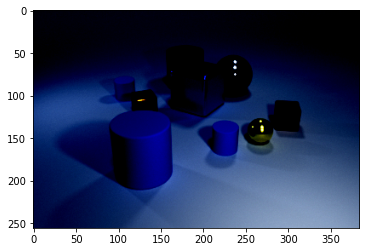

In [ ]:
plt.imshow(feed_dict_k["image"][1].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


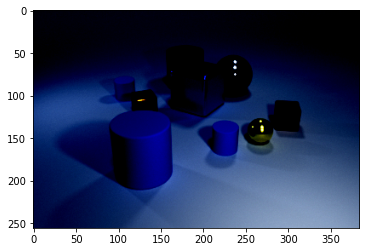

In [ ]:
plt.imshow(feed_dict_q["image"][1].permute(1,2,0))